In [2]:
import numpy as np
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import seaborn as sb

ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
def load_data():
    data = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/data.txt",  encoding='utf-8',sep='\t',lineterminator='\n',names=['USER','MOVIE','RATING'],header=None)
    train = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/train.txt",  encoding='utf-8',sep='\t',lineterminator='\r',names=['USER','MOVIE','RATING'],header=None)
    test = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/test.txt",  encoding='utf-8',sep='\t',lineterminator='\r',names=['USER','MOVIE','RATING'],header=None)
    movies = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/movies.txt", encoding='latin-1',sep='\t',header=None)
    movies.columns=['MOVIE_ID','TITLE','UNKNOWN','ACTION','ADVENTURE','ANIMATION','CHILDREN','COMEDY','CRIME','DOCUMENTARY','DRAMA','FANTASY','FILM-NOIR','HORROR','MUSICAL','MYSTERY','ROMANCE','SCI-FI','THRILLER','WAR','WESTERN']
    return data,movies,train,test

In [8]:
data,movies,train,test = load_data()

In [11]:
print(test)

      USER  MOVIE  RATING
0      707    766       3
1      943    188       4
2      772    313       5
3      828     26       3
4      854    514       4
...    ...    ...     ...
9995    13    858       1
9996     7     79       4
9997   588   1058       2
9998   916    727       4
9999   833    118       2

[10000 rows x 3 columns]


In [2]:
%load_ext blackcellmagic

In [3]:
def grad_U_biased(Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    gradU = reg * Ui - (Yij - np.dot(Ui, Vj) - ai - bj) * Vj
    return gradU * eta


def grad_V_biased(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    gradV = reg * Vj - (Yij - np.dot(Ui, Vj) - ai - bj) * Ui
    return gradV * eta


def grad_a_biased(Vj, Yij, Ui, ai, bj, reg, eta):
    grada = reg * ai - (Yij - np.dot(Ui, Vj) - ai - bj)
    return grada * eta


def grad_b_biased(Vj, Yij, Ui, ai, bj, reg, eta):
    gradb = reg * bj - (Yij - np.dot(Ui, Vj) - ai - bj)
    return gradb * eta


def get_err_biased(U, V, Y, a, b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum = 0
    for i in range(0, Y.shape[0]):
        sum = (
            sum
            + (
                Y[i, 2]
                - np.dot(U[Y[i, 0] - 1, :], V[Y[i, 1] - 1, :])
                - a[Y[i, 0] - 1]
                - b[Y[i, 1] - 1]
            )
            ** 2
        )
    loss = (
        reg
        / 2
        * (
            np.linalg.norm(U, ord="fro") ** 2
            + np.linalg.norm(V, ord="fro") ** 2
            + np.linalg.norm(a) ** 2
            + np.linalg.norm(b) ** 2
        )
        + sum / 2
    )
    return loss / (Y.shape[0])


def train_model_biased(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    err = np.inf
    cur_epoch = 0

    # generate random U,V
    U = np.random.rand(M, K)
    U = U - 0.5 * np.ones_like(U)
    V = np.random.rand(N, K)
    V = V - 0.5 * np.ones_like(V)
    a = np.random.rand(M)
    a = a - 0.5 * np.ones_like(a)
    b = np.random.rand(N)
    b = b - 0.5 * np.ones_like(b)
    print(b.shape)

    # Perform SGD
    prev_err = 0
    while cur_epoch < max_epochs and np.abs(prev_err - err) > eps:
        prev_err = err

        # shuffle indices
        ind_shuff = np.arange(Y.shape[0])
        np.random.shuffle(ind_shuff)
        for k in range(0, ind_shuff.shape[0]):
            i = Y[ind_shuff[k], 0] - 1
            j = Y[ind_shuff[k], 1] - 1
            Yij = Y[ind_shuff[k], 2]
            U[i, :] = U[i, :] - grad_U(U[i, :], Yij, V[j, :], a[i], b[j], reg, eta)
            V[j, :] = V[j, :] - grad_V(V[j, :], Yij, U[i, :], a[i], b[j], reg, eta)
            a[i] = a[i] - grad_a(V[j, :], Yij, U[i, :], a[i], b[j], reg, eta)
            b[j] = b[j] - grad_b(V[j, :], Yij, U[i, :], a[i], b[j], reg, eta)

        # Calculate error
        err = get_err(U, V, Y, a, b, reg)
        cur_epoch = cur_epoch + 1
        print(cur_epoch)
        print(err)

    err = get_err(U, V, Y, a, b)

    return U, V, a, b, err

Factorizing with  943  users,  1682  movies.
(1682,)
1
0.4988531479526404
2
0.4326334037892846
3
0.40923782139636883
4
0.3934356306090644
5
0.37941842673946546
6
0.3679310630402098
7
0.3583611309291101
8
0.34963329880936284
9
0.3425478473336185
10
0.3354918553802317
11
0.32919445012646653
12
0.3247028212380967
13
0.3206301604541718
14
0.3173275560533743
15
0.3133159326516409
16
0.31038357660455224
17
0.30886704576866414
18
0.30655470077062535
19
0.3041374236081655
20
0.30271500874544865
21
0.30139954738903135
22
0.2999210215097526
23
0.2986875882414783
24
0.29820901330042876
25
0.2976031584374654
26
0.2955364327940185
27
0.2948329826669647
28
0.29492887302220183
(1682,)
1
0.43636314329248815
2
0.35653035111025255
3
0.32804528384653087
4
0.31231776996700567
5
0.2995066882261607
6
0.28847362682374533
7
0.2797883531024754
8
0.2720386795662823
9
0.26503858787834444
10
0.2601663079200536
11
0.25459731819728304
12
0.2499717482692954
13
0.24672060786269637
14
0.24245552515937202
15
0.23943311

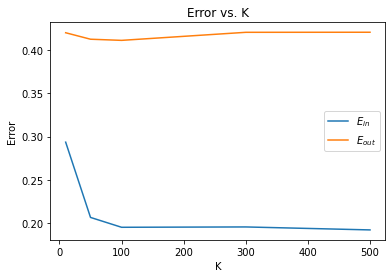

In [78]:
Y_train = train.to_numpy()
Y_test = test.to_numpy()

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = [10,50,100,300,500]

reg = 0.1
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U_best = []; V_best = []; a_best = []; b_best = [];
cur_err = np.inf
for K in Ks:
    U,V,a,b, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    test_err = get_err(U, V, Y_test,a,b)
    E_out.append(test_err)
    if test_err<cur_err:
        U_best = U; V_best = V; a_best = a; b_best = b;
        cur_err = test_err

plt.plot(Ks, E_in, label='$E_{in}$')
plt.plot(Ks, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2d.png')

Factorizing with  943  users,  1682  movies.
(1682,)
1
0.46655173662669785
2
0.3675673126556833
3
0.32027260982395683
4
0.28847230901264875
5
0.26499285752113194
6
0.2477554260580386
7
0.2344978023543375
8
0.22424130615091362
9
0.21684234023919088
10
0.21005033181078894
11
0.20472069090366984
12
0.20021548573447115
13
0.1975398239219735
14
0.19373520950675416
15
0.19178682935585784
16
0.18963515440547654
17
0.18769517852816842
18
0.18628905704774398
19
0.18575438572397604
20
0.18455817781565526
21
0.18432475436325046
22
0.18370348360868258
23
0.18344556116985922
24
0.1835170972007036
(1682,)
1
0.47502919091293166
2
0.3743708365664461
3
0.3251670167603751
4
0.29177474351983845
5
0.26668576897906576
6
0.24820185331259104
7
0.23429180265674973
8
0.22271567463406447
9
0.21387690661957123
10
0.20671241647197913
11
0.19982875728439387
12
0.19473880205887392
13
0.1900417217879584
14
0.18598761639285977
15
0.1823557492781045
16
0.17912704036590418
17
0.1763728265208868
18
0.17434108792682038
1

<ipython-input-51-0db4738b49a8>:30: RuntimeWarning: invalid value encountered in double_scalars
  gradb = -(Yij-np.dot(Ui,Vj)-ai-bj)
<ipython-input-51-0db4738b49a8>:22: RuntimeWarning: overflow encountered in multiply
  gradV = reg*Vj-(Yij-np.dot(Ui,Vj)-ai-bj)*Ui;
<ipython-input-51-0db4738b49a8>:22: RuntimeWarning: invalid value encountered in double_scalars
  gradV = reg*Vj-(Yij-np.dot(Ui,Vj)-ai-bj)*Ui;
<ipython-input-51-0db4738b49a8>:10: RuntimeWarning: overflow encountered in multiply
  gradU = reg*Ui-(Yij-np.dot(Ui,Vj)-ai-bj)*Vj;


1
nan


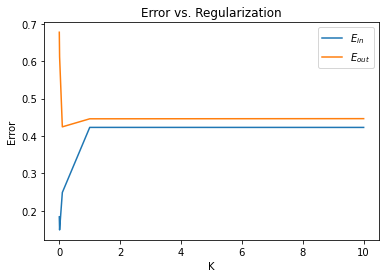

In [176]:
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20
regs = [0,0.01,0.1,1,10,100]
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U_best = []; V_best = []; a_best = []; b_best = [];
cur_err = np.inf
for reg in regs:
    U,V,a,b, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    test_err = get_err(U, V, Y_test,a,b)
    E_out.append(test_err)
    if test_err<cur_err:
        U_best = U; V_best = V; a_best = a; b_best = b;
        cur_err = test_err

plt.plot(regs, E_in, label='$E_{in}$')
plt.plot(regs, E_out, label='$E_{out}$')
plt.title('Error vs. Regularization')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2d.png')

In [177]:
#Compute SVD;
A,S,B = np.linalg.svd(V_best.T)
print(A.shape)
print(V_best.shape)
Vtilde = V_best@A[:,0:2]
Utilde = U_best@A[:,0:2]
print(Utilde.shape)

(20, 20)
(1682, 20)
(943, 2)


In [175]:
np.savetxt("nr_Vtilde.csv", Vtilde, delimiter=",")
np.savetxt("nr_Utilde.csv", Vtilde, delimiter=",")

Int64Index([   6,   37,   38,   49,   61,   81,   83,   88,   95,  100,
            ...
            1214, 1239, 1273, 1292, 1385, 1410, 1415, 1418, 1471, 1595],
           dtype='int64', length=101)
Int64Index([   0,    3,    7,   12,   15,   16,   20,   24,   25,   28,
            ...
            1646, 1648, 1653, 1654, 1655, 1658, 1663, 1667, 1669, 1680],
           dtype='int64', length=505)
Int64Index([  31,   47,   74,  114,  118,  319,  359,  633,  643,  644,  676,
             700,  756,  765,  810,  812,  813,  846,  849,  856,  883,  953,
             972, 1021, 1064, 1083, 1127, 1129, 1140, 1141, 1183, 1200, 1231,
            1293, 1306, 1317, 1330, 1362, 1365, 1377, 1481, 1496, 1546, 1560,
            1561, 1584, 1593, 1628, 1640, 1648],
           dtype='int64')


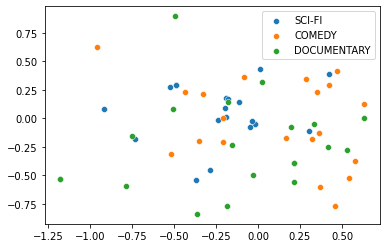

In [178]:
#Get representative datapoints
clusters = ['SCI-FI','COMEDY','DOCUMENTARY']
n_cluster = 20
cluster_data = np.zeros((n_cluster,2,len(clusters)))
for c in range(0,len(clusters)):
    genre_data = movies[lambda x: x[clusters[c]]==1]
    print(genre_data.index)
    cluster_inds = np.random.choice(genre_data['MOVIE_ID'],n_cluster)
    cluster_data[:,:,c] = Vtilde[cluster_inds,:]

plt.figure()
for c in range(0,len(clusters)):
    sb.scatterplot(x=cluster_data[:,0,c],y=cluster_data[:,1,c])

plt.legend(clusters)
        

In [166]:

def visualize(inds, Vtilde,movies, data,title):
    genres = ['UNKNOWN','ACTION','ADVENTURE','ANIMATION','CHILDREN','COMEDY','CRIME','DOCUMENTARY','DRAMA','FANTASY','FILM-NOIR','HORROR','MUSICAL','MYSTERY','ROMANCE','SCI-FI','THRILLER','WAR','WESTERN']
    hue_data = np.zeros(len(inds))
    for i in range(0,len(inds)):
        hue_data[i] = np.mean(data[lambda x: x['MOVIE']==inds[i]]['RATING'].to_numpy())

    plt.figure(figsize=(20,10))
    sb.scatterplot(x=Vtilde[inds,0],y=Vtilde[inds,1],hue=hue_data)
    for i in range(0,len(inds)):
        title_str = movies[lambda x: x['MOVIE_ID']==inds[i]]['TITLE'].values[0] + '\n'
        for g in genres:
            if movies[lambda x: x['MOVIE_ID']==inds[i]][g].values[0] == 1:
                title_str = title_str+','+g
        plt.text(x=Vtilde[inds[i],0]+0.01,y=Vtilde[inds[i],1],s=title_str)
    plt.axhline(0,color='black',linestyle='--') # x = 0
    plt.axvline(0,color='black',linestyle='--') # y = 0
    plt.xlabel('1st Projected V Component')
    plt.ylabel('2nd Projected V Component')
    plt.title(title)

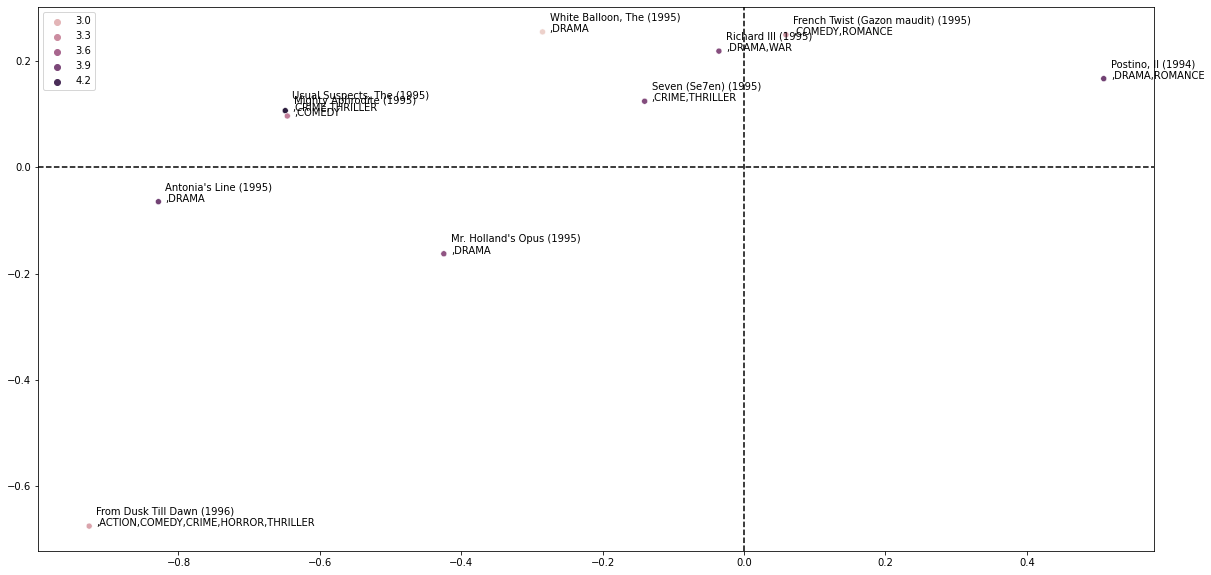

In [140]:
#Plot 10 movies
inds = range(10,20)

visualize(inds,Vtilde,movies,data)

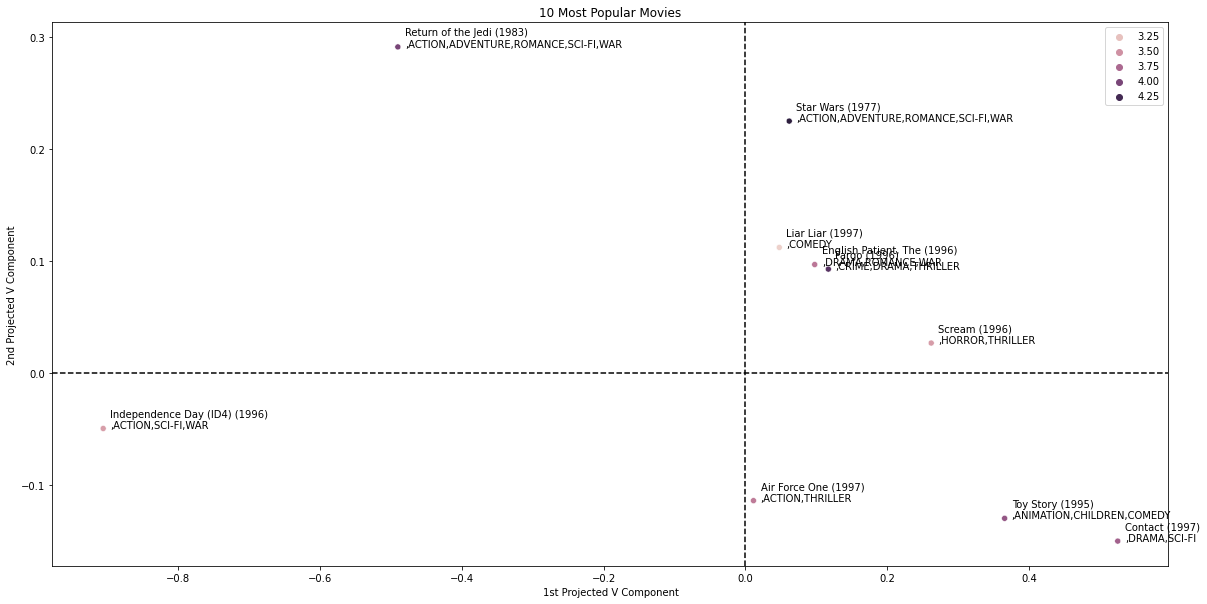

In [179]:
popular = [50, 258, 100, 181, 294, 286, 288, 1, 300, 121]
visualize(popular,Vtilde,movies,data,'10 Most Popular Movies')

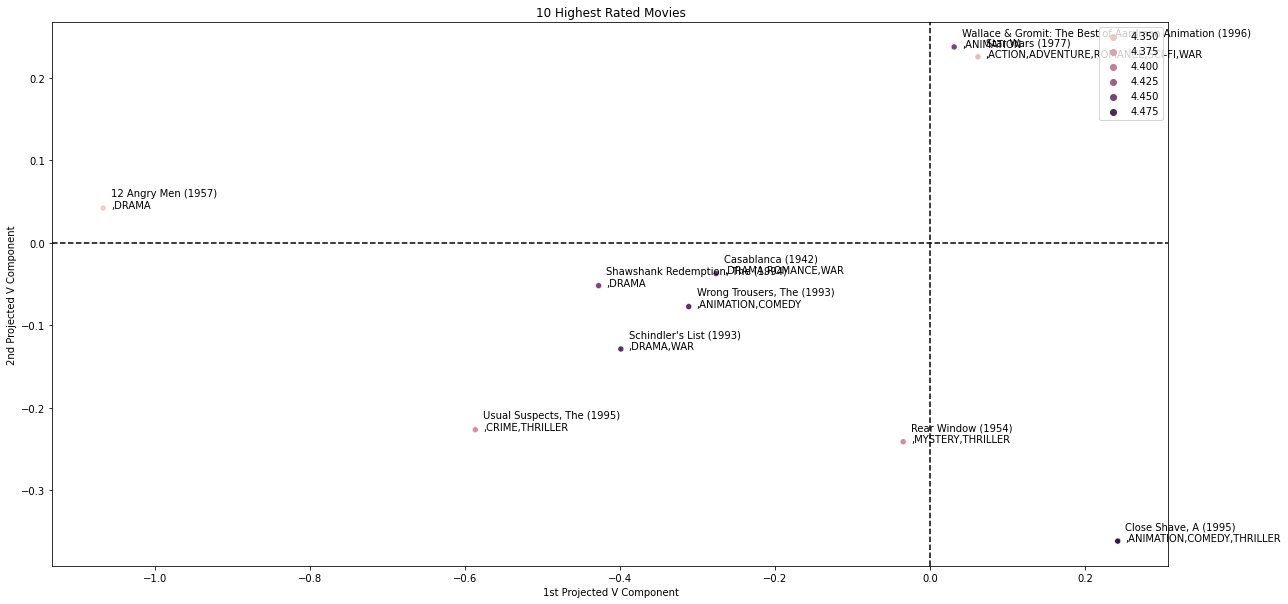

In [180]:
best = [408, 318, 169, 483, 114,  64, 603,  12,  50, 178]
visualize(best,Vtilde,movies,data,'10 Highest Rated Movies')

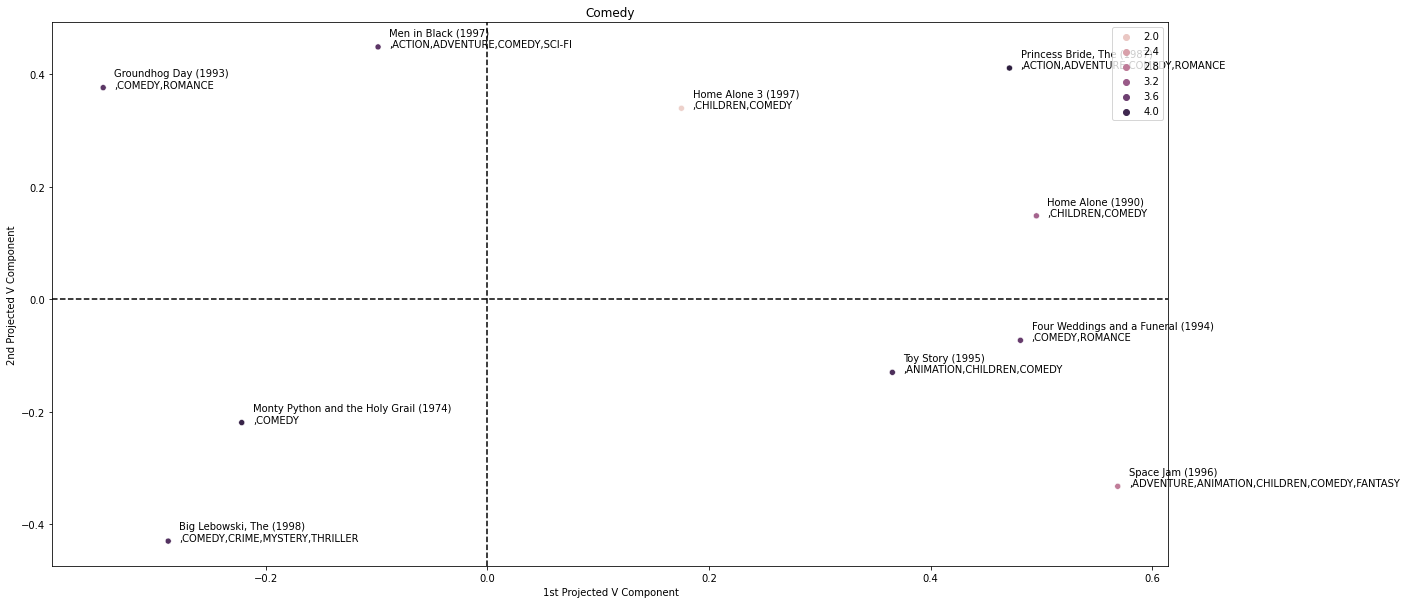

In [181]:
#Comedy movies
comedy_inds = [1,70,94,168,202,257,894,902,820,173]
visualize(comedy_inds,Vtilde,movies,data,'Comedy')

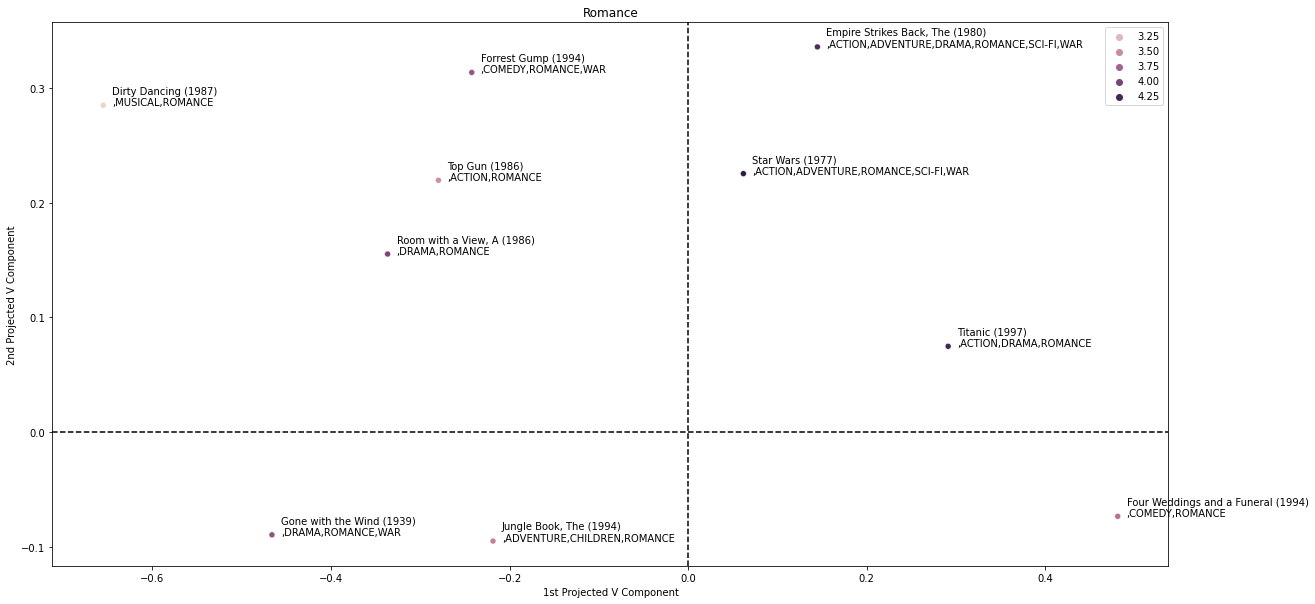

In [182]:
#Romance
doc_ids = [50,69,70,133,155,161,172,213,313,465]
visualize(doc_ids,Vtilde,movies,data,'Romance')

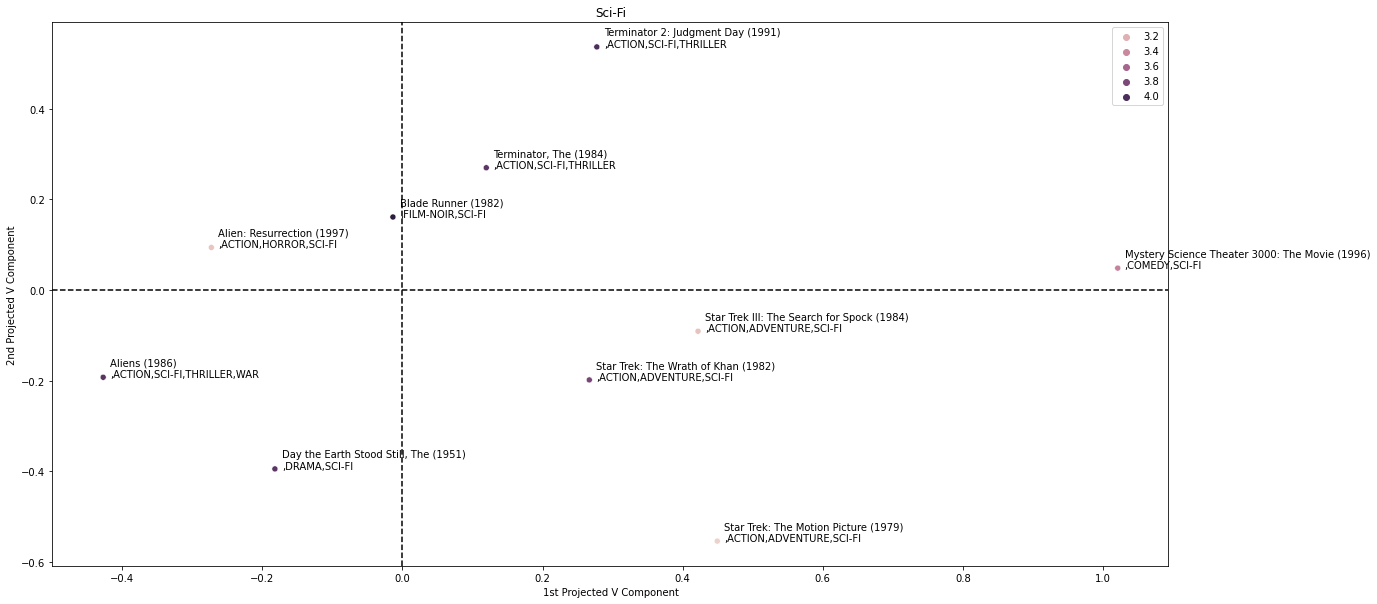

In [170]:
#sci-fi
scifi_ids = [89,96,109,176,195,228,229,343,429,449]
visualize(scifi_ids,Vtilde,movies,data,'Sci-Fi')